# Trading Analysis (10, 200)

## Summary: This code will be used to simulate Profit and Loss (per Stock, independent of other stocks) based on 10, 200 days rule


1. Buy stock (next day) if 10 day MA > 200 day MA (Given 10 day MA < 200 day MA before)
    
2. Close the Position when 10 day MA < 200 day MA 

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
# Get current working directory
mycwd = os.getcwd()
print(mycwd)

C:\Users\sidhu\OneDrive\Indian-Markets-Trading-Strategy\Dev\Codes


## Functions

In [3]:
def Get_TradeSignal(filename):
    """
    Do below steps
        1. Calculate 'Difference 1': 'MA 10' - 'MA 200'
        2. Calculate 'Difference 2': 'MA 10' - 'MA 20'
        3. Buy Signal: if MA10 crosses MA200 buy the stock on next day at High of the day
        3. Position Close Signal: If MA10 falls below MA200 sell the stock on next day at low of the day
        NOTE: Buying at High and selling at Low is to simulate worst possible behavior of a trader 
        (for panic buy or panic sell)
    """
    # Read the file
    df = pd.read_csv(filename+".csv", index_col = "Date")
    df.index = pd.to_datetime(df.index)
    # Drop values with nan
    df.dropna(inplace=True)
    # Calculae difference between Moving Averages
    df['Difference'] = np.where((df['MA 10'] - df['MA 200']) > 0, 1, -1)
    # Calculate The Buy and Sell Signal
    df['Signal'] = df['Difference'].diff(1)
    df['BuyExit'] = np.where(df['Signal'] == 2, 1, np.where(df['Signal'] == -2, -1, np.NAN))
    df.drop("Signal", axis=1, inplace=True)
    # Shift Buy, Sell Signal to next day (due to delay in available information
    # Asset will be bought at High of the day, and sold at low of the day (conservative approach)
    df['BuyExit'] = df['BuyExit'].shift(1)
    df['BuyExitPrice'] = np.where(df['BuyExit'] == 1, df['High'], np.where(df['BuyExit'] == -1, -df['Low'], np.NAN))
    return df

In [4]:
def ReturnProfitLoss(filename):
    """
    Input: filename
    -- Calls Get_TradeSignal function to get Buy and Exit days and price
    -- Calculates total number of trades executed in the time period
    -- Calculates % of profitable trades
    -- Calculates % Profit (with respect to start price of first time buy)
    -- Returns above 3 metrics in form of a list
    """
    # Count number of trades, number of profitable trades, and total profit
    df = Get_TradeSignal(filename)
    BuyExitPrice = list(df['BuyExitPrice'].dropna())
    # Required processing
    if (len(BuyExitPrice) > 0):
        if(BuyExitPrice[0] < 0):
            BuyExitPrice.pop(0)
        list_len = len(BuyExitPrice)
        if(len(BuyExitPrice)%2 > 0):
            BuyExitPrice.append(-1*df.iloc[-1]["Low"])
        NumberofTrades = int(len(BuyExitPrice)/2)
        Profit = (-1 * np.array(BuyExitPrice).reshape(-1,1).sum())/BuyExitPrice[0]
        Profitabletrades = 0
        for i in range(0, NumberofTrades):
            if(BuyExitPrice[2*i] < -1*BuyExitPrice[1+2*i]):
                Profitabletrades += 1
        Profitabletrades = Profitabletrades/NumberofTrades
    else:
        NumberofTrades = 0
        Profitabletrades = 0
        Profit = 0        
    outplist = [NumberofTrades, Profitabletrades, Profit]
    return outplist

## Part 1: Read the Dictionaries

In [5]:
# Change to Models directory to read the dictionaries storing "tickers"
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Models")

In [6]:
# Read NIFTY50 Dictionary
with open('NIFTY50.pkl', 'rb') as f:
    NIFTY50 = pickle.load(f)

In [7]:
# Read NIFTYNEXT50 Dictionary
with open('NIFTYNEXT50.pkl', 'rb') as f:
    NIFTYNEXT50 = pickle.load(f)

In [8]:
# Read NIFTYMIDCAP100 Dictionary
with open('NIFTYMIDCAP100.pkl', 'rb') as f:
    NIFTYMIDCAP100 = pickle.load(f)

In [9]:
# Read OTHERINDICES Dictionary
with open('OTHERINDICES.pkl', 'rb') as f:
    OTHERINDICES = pickle.load(f)

<span style="color:Green"> __Comments:__ To explore the code for other markets, please make relevant changes in above dictionaries 

## Part 2: Trading Strategy

In [10]:
# Change to Data directory to read the dictionaries storing "tickers"
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

### Part 2.1: Trading Strategy for NIFTY50 stocks

In [11]:
# Create a list of NIFTY50 Stocks
NIFTY50_KEYS = list(NIFTY50.keys())

In [12]:
# Loop over the NIFTY50 list and save the data for the stock
results = {}
for stock in NIFTY50_KEYS:
    results[stock] = ReturnProfitLoss(stock)

In [13]:
# Create results dataframe
results = pd.DataFrame(results).T
results.columns = ["Number of Trades", "Profitable Trades", "Profit/Loss %"]
results["50 %"] = 0.5

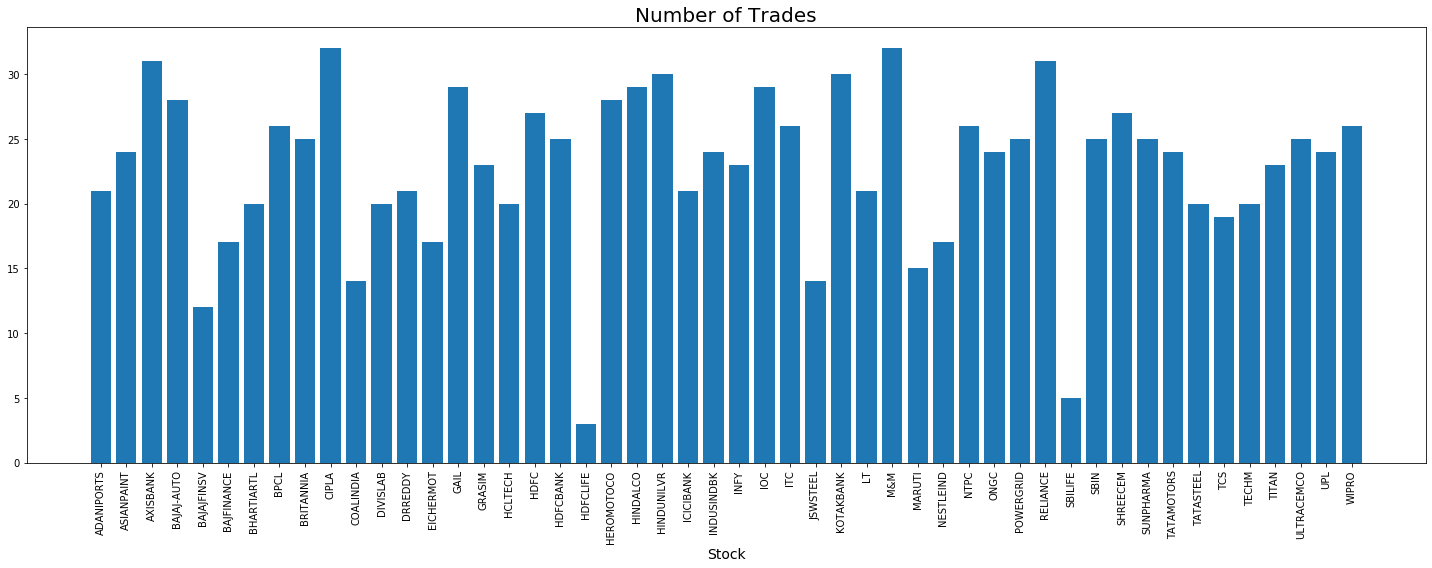

In [14]:
# Change directory to Images folder
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")
# Plot total number of trades executed
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Number of Trades"], label="Number of Trades")
plt.title("Number of Trades", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Nifty50 MA10 200 Number of Trades.png")
plt.show()

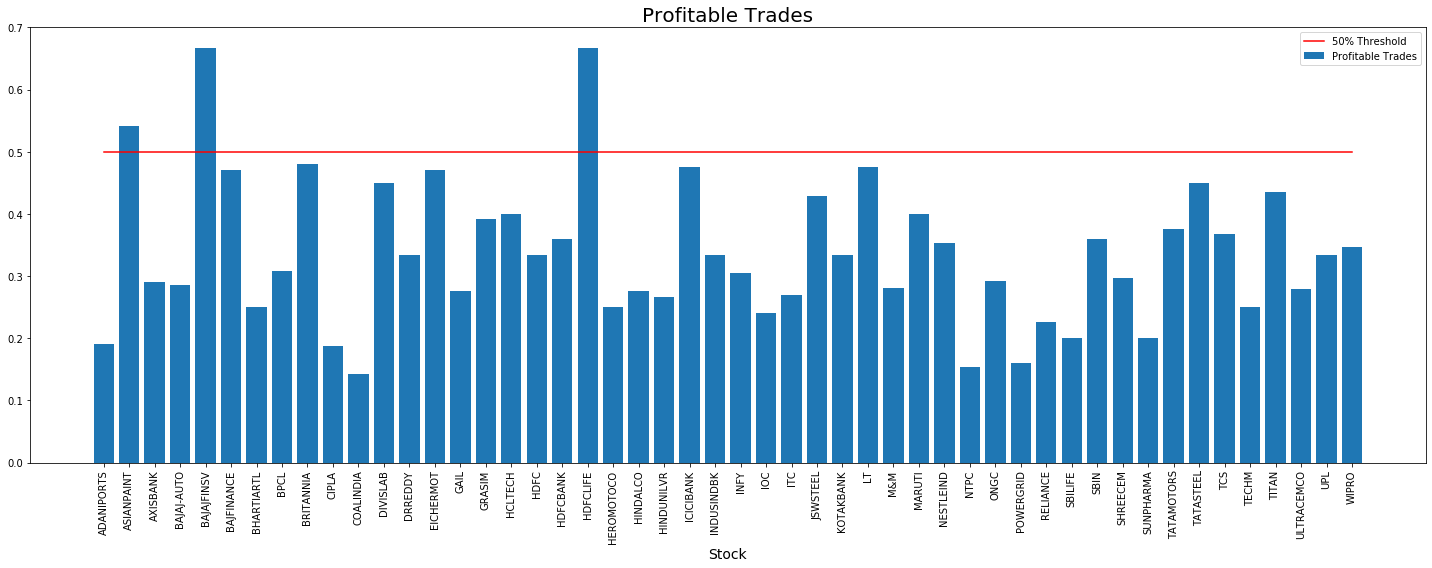

In [15]:
# Plot total percentage of profitable trades
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Profitable Trades"], label="Profitable Trades")
plt.plot(results['50 %'], 'r', label="50% Threshold")
plt.title("Profitable Trades", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("Nifty50 MA10 200 Profitable Trades.png")
plt.show()

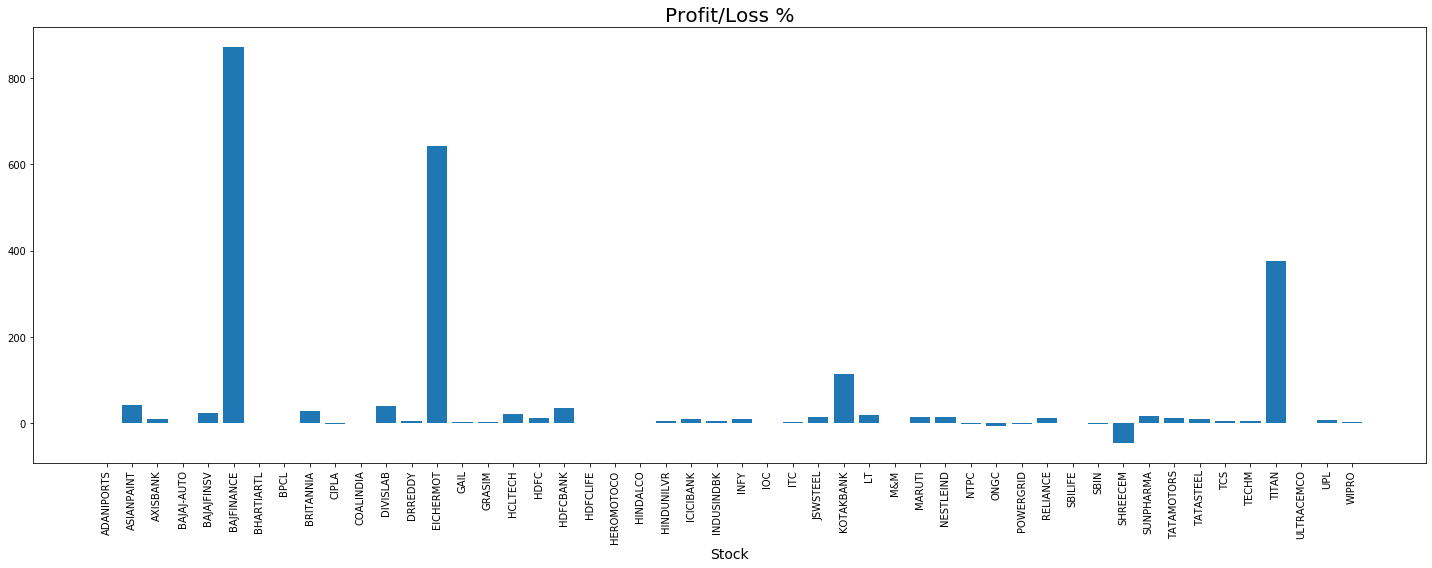

In [16]:
# Plot % profit over the time period
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Profit/Loss %"], label="Profit/Loss %")
plt.title("Profit/Loss %", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Nifty50 MA10 200 Profit Loss.png")
plt.show()

### Part 2.2: Trading Strategy for NIFTYNEXT50 stocks

In [17]:
# Create a list of NIFTYNEXT50 Stocks
NIFTYNEXT50_KEYS = list(NIFTYNEXT50.keys())
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [18]:
# Loop over the NIFTYNEXT50 list and save the data for the stock
results = {}
for stock in NIFTYNEXT50_KEYS:
    results[stock] = ReturnProfitLoss(stock)

In [19]:
# Create results dataframe
results = pd.DataFrame(results).T
results.columns = ["Number of Trades", "Profitable Trades", "Profit/Loss %"]
results["50 %"] = 0.5

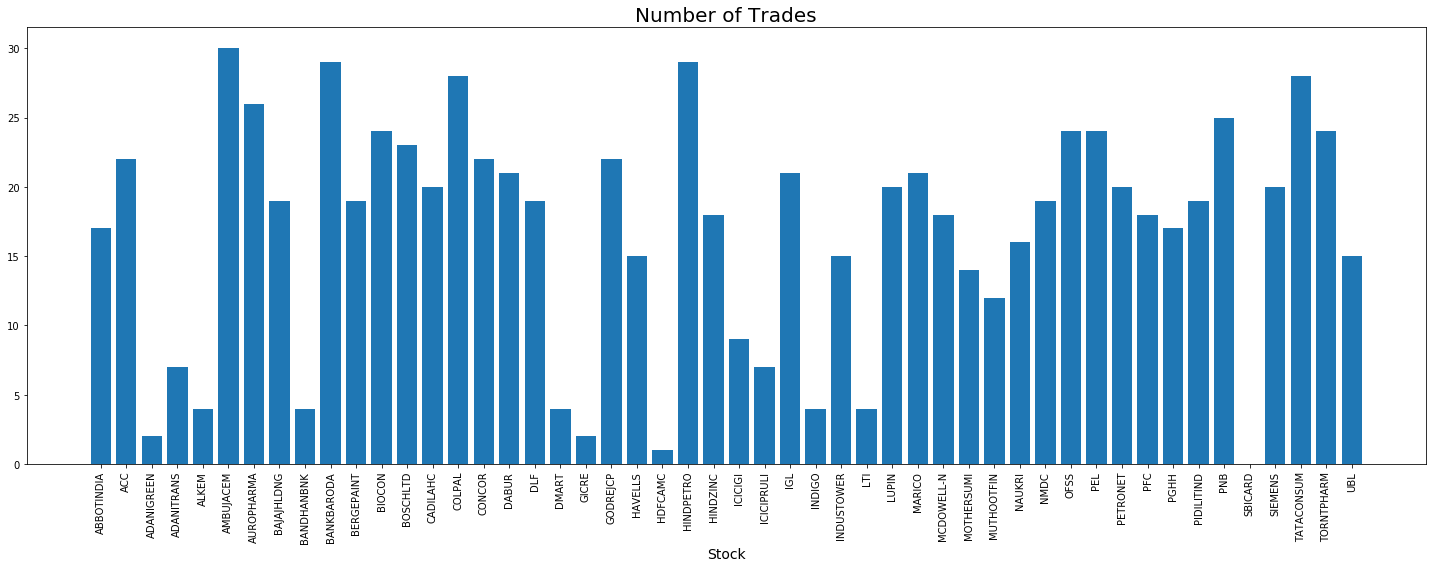

In [20]:
# Change directory to Images folder
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")
# Plot total number of trades executed
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Number of Trades"], label="Number of Trades")
plt.title("Number of Trades", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("NIFTYNEXT50 MA10 200 Number of Trades.png")
plt.show()

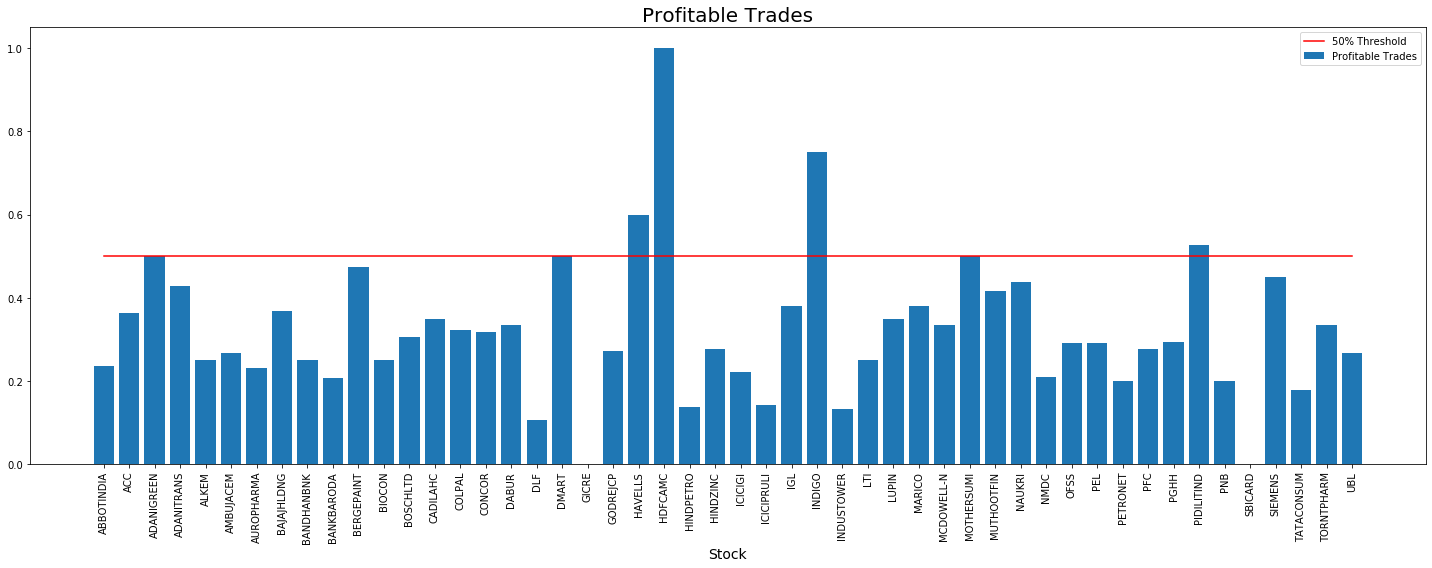

In [21]:
# Plot total percentage of profitable trades
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Profitable Trades"], label="Profitable Trades")
plt.plot(results['50 %'], 'r', label="50% Threshold")
plt.title("Profitable Trades", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("NIFTYNEXT50 MA10 200 Profitable Trades.png")
plt.show()

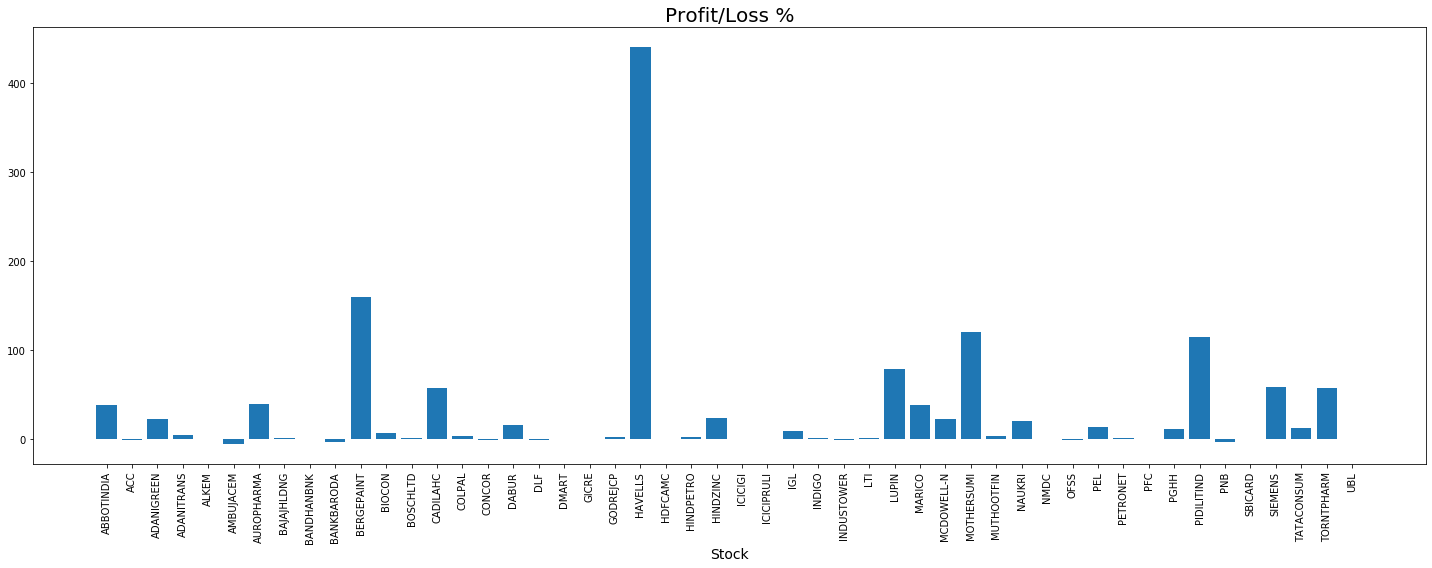

In [22]:
# Plot % profit over the time period
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Profit/Loss %"], label="Profit/Loss %")
plt.title("Profit/Loss %", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("NIFTYNEXT50 MA10 200 Profit Loss.png")
plt.show()

### Part 2.3: Trading Strategy for NIFTYMIDCAP100 stocks

In [23]:
# Create a list of NIFTYMIDCAP100 Stocks
NIFTYMIDCAP100_KEYS = list(NIFTYMIDCAP100.keys())
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [24]:
# Loop over the NIFTYMIDCAP100 list and save the data for the stock
results = {}
for stock in NIFTYMIDCAP100_KEYS:
    results[stock] = ReturnProfitLoss(stock)

In [25]:
# Create results dataframe
results = pd.DataFrame(results).T
results.columns = ["Number of Trades", "Profitable Trades", "Profit/Loss %"]
results["50 %"] = 0.5

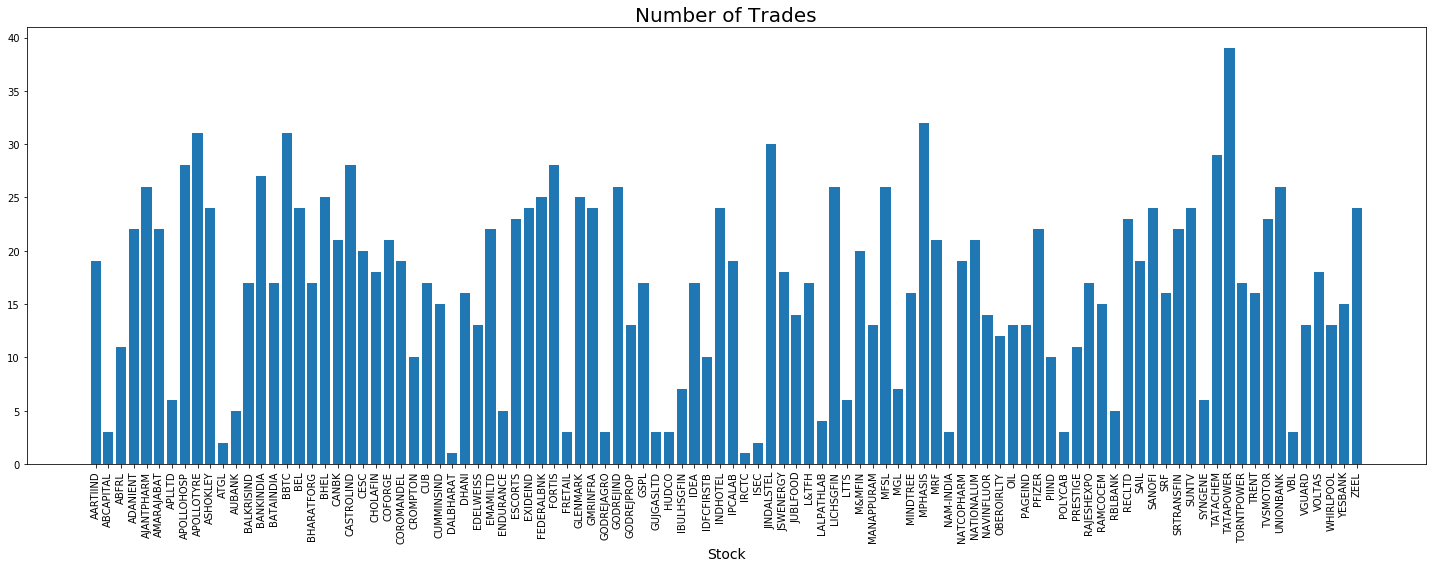

In [26]:
# Change directory to Images folder
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Images")
# Plot total number of trades executed
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Number of Trades"], label="Number of Trades")
plt.title("Number of Trades", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("NIFTYMIDCAP100 MA10 200 Number of Trades.png")
plt.show()

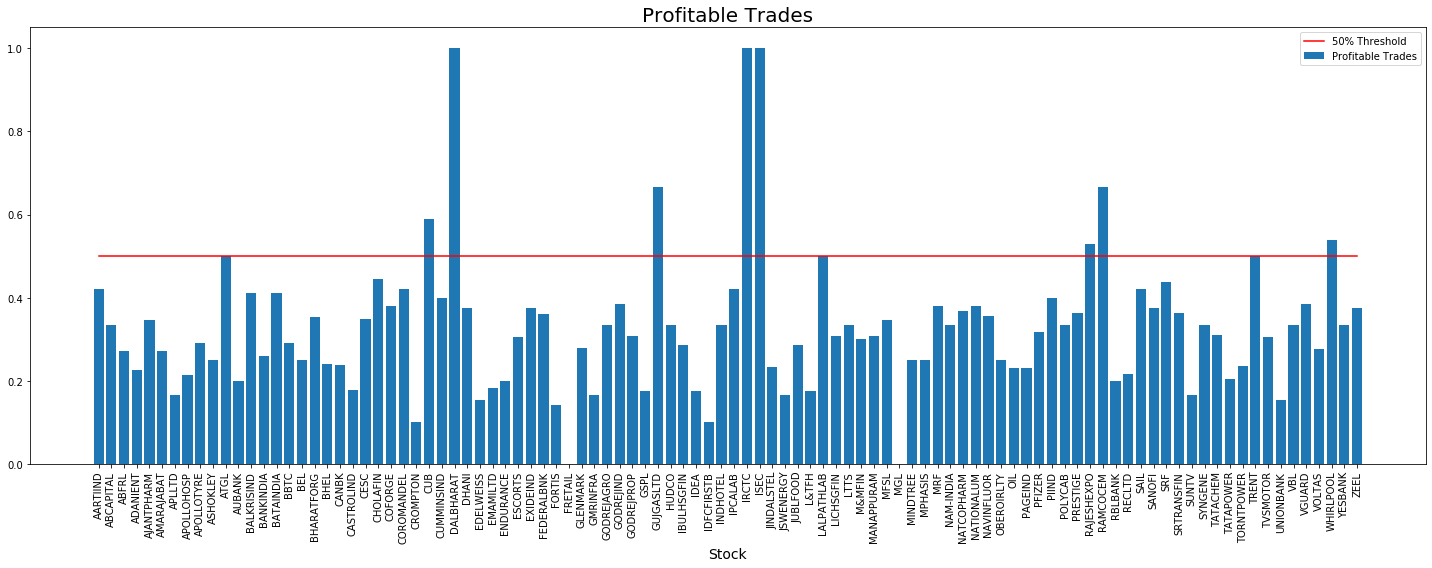

In [27]:
# Plot total percentage of profitable trades
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Profitable Trades"], label="Profitable Trades")
plt.plot(results['50 %'], 'r', label="50% Threshold")
plt.title("Profitable Trades", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("NIFTYMIDCAP100 MA10 200 Profitable Trades.png")
plt.show()

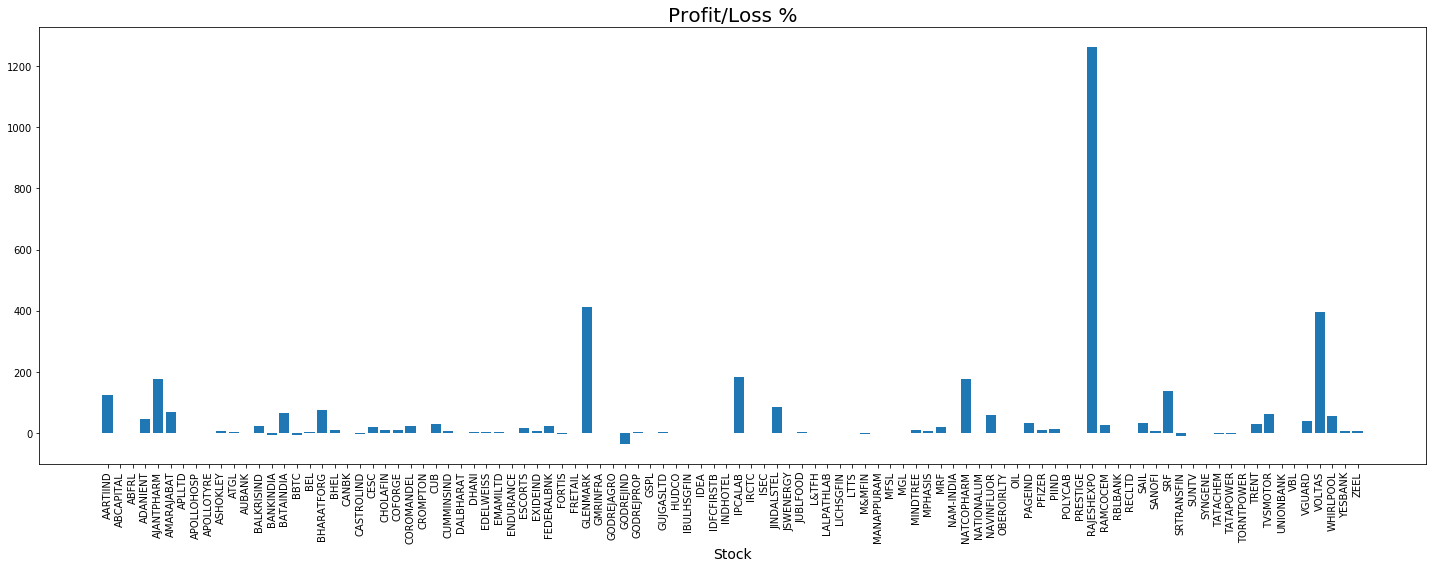

In [28]:
# Plot % profit over the time period
plt.figure(figsize=(20,8))
plt.bar(results.index, results["Profit/Loss %"], label="Profit/Loss %")
plt.title("Profit/Loss %", fontsize=20)
plt.xlabel("Stock", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("NIFTYMIDCAP100 MA10 200 Profit Loss.png")
plt.show()

<span style="color:Green"> __Comments:__ In most of stocks, more than 50% of trades are not profitable. Hence we need to add another rule to help improve this trading strategy